# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,2.320834,True,9.387020
1,0.630983,True,5.141012
2,0.787696,True,6.482143
3,0.313930,True,3.755315
4,-0.825402,False,-1.123015
...,...,...,...
995,1.691128,False,2.784874
996,1.718268,True,6.549160
997,0.990501,False,0.895541
998,0.782459,False,1.923253


<Axes: xlabel='v0'>

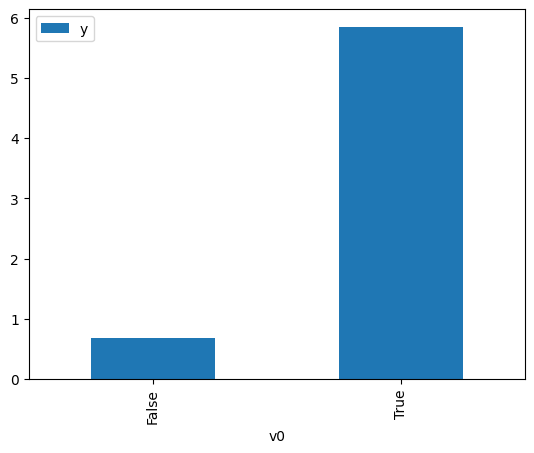

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

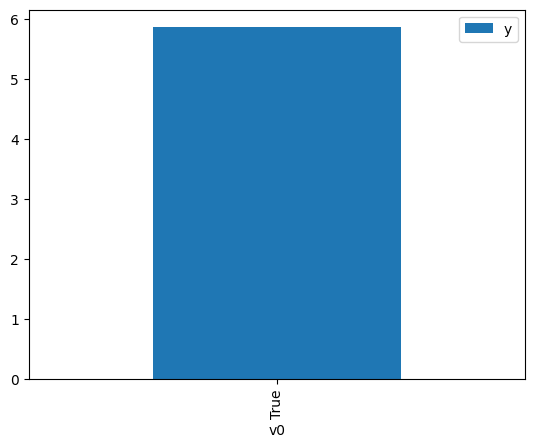

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.967933,False,2.374093,0.265922,3.760506
1,0.123584,False,0.240748,0.471160,2.122422
2,-0.662530,False,-0.985252,0.673129,1.485600
3,0.124534,False,-0.041452,0.470908,2.123559
4,0.244441,False,1.177962,0.439227,2.276729
...,...,...,...,...,...
995,-0.264735,False,0.020883,0.574049,1.742012
996,1.989762,False,4.073871,0.108660,9.203018
997,1.312464,False,1.212648,0.200588,4.985339
998,0.940295,False,0.354984,0.271711,3.680375


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.451394,True,9.171554,0.822108,1.216385
1,1.518636,True,7.735094,0.832349,1.201419
2,1.342122,True,6.768357,0.804433,1.243112
3,0.953463,True,6.552904,0.731057,1.367883
4,1.124401,True,8.224632,0.765340,1.306609
...,...,...,...,...,...
995,0.939374,True,7.883053,0.728094,1.373448
996,0.386453,True,6.776307,0.597645,1.673235
997,0.481538,True,5.672825,0.621755,1.608351
998,0.807014,True,7.131737,0.699287,1.430029


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                          1.407e+04
Date:                Mon, 27 Oct 2025   Prob (F-statistic):                        0.00
Time:                        20:47:17   Log-Likelihood:                         -1408.1
No. Observations:                1000   AIC:                                      2820.
Df Residuals:                     998   BIC:                                      2830.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6716      0.035     48.176      0.000       1.604       1.740
x2             5.0080      0.050     99.886      0.000       4.910       5.106
==============================================================================
Omnibus:                        0.431   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.806   Jarque-Bera (JB):                0.313
Skew:                          -0.001   Prob(JB):                        0.855
Kurtosis:                       3.087   Cond. No.                         2.22
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""